In [2]:
import my_keys

key = my_keys.keys['guardian']

#https://gist.github.com/dannguyen/c9cb220093ee4c12b840

import re 
import requests
import pickle
from bs4 import BeautifulSoup
import json

In [154]:
API_ENDPOINT = 'https://content.guardianapis.com/fashion/2019/mar/16/what-not-to-wear-if-you-are-a-man-over-50'


#API_ENDPOINT = 'https://content.guardianapis.com/tags'
#API_ENDPOINT = 'https://content.guardianapis.com/business/2014/feb/18/uk-inflation-falls-below-bank-england-target'

my_params = {
    #'show-blocks' : 'body:latest',
    'show-tags' : 'all',
    'api-key': my_keys.keys['guardian']
}

r = requests.get(API_ENDPOINT, my_params)


In [156]:
r.text

'{"response":{"status":"error","message":"You are not permitted to access this content via your current user tier."}}'

In [155]:
dd = json.loads(r.text) 
[x['id'] for x in dd['response']['content']['tags'] if x['type'] == 'keyword']


KeyError: 'content'

Once you have a tag then it it is easy to pull related content using the API

In [176]:
API_ENDPOINT = 'https://content.guardianapis.com/search'

search_params = {
    'q' : '(over AND 50)',
    'from-date': "2010-01-01",
    'to-date': "2019-01-01",
    'order-by': "newest",
    'show-fields': 'all',
    'page-size': 200,
    'tag' : 'fashion/fashion',
    #'tag' : 'education/mathematics',
    'api-key': key
}

r = requests.get(API_ENDPOINT, search_params)

dd = json.loads(r.text)
dd['response'].keys()

dict_keys(['status', 'userTier', 'total', 'startIndex', 'pageSize', 'currentPage', 'pages', 'orderBy', 'results'])

In [211]:
pp = re.compile('over \d+ ')
ps = re.compile('over-\d+')

dx = [x for x in results if ps.findall(x['fields']['bodyText'])]

In [212]:
len(dx)

11

In [213]:
results = dd['response']['results']
stuff = [x['webTitle'] for x in dx  ]
print('\n'.join(stuff))

Monkey Tennis may yet see the light of day | Brief letters
The millennial-pink pound: a right-on fashion phenomenon
Is it time to ditch the term 'anti-ageing'?
The salt-and-pepper pound: where are all the fiftysomething models?
Fashion wakes up to the older woman
More middle-aged men taking steroids to look younger
Mary Portas: 'Things are better for women on the high street today than when we started'
Helen Mirren: â€˜Do I feel beautiful? I hate that wordâ€™
Nick Grimshaw: â€˜Nobody gives you a job because you know Harry Stylesâ€™
Giving up the bottle â€“  accepting greying hair
Where are all the plus-size male models?


In [216]:

print(dx[1]['fields']['bodyText'])

Babe Power is the fastest-selling female fragrance of 2017. It comes in an 80ml rose gold â€œcanâ€�, costs Â£28 and claims to smell of absinthe, moss and candy floss. Itâ€™s the honk of the candy floss that stays with you, though, clinging to your sleeve with resolve hours after application. The debut perfume from British brand Missguided, it describes its wearers as â€œbabes!â€�. A more accurate description may be â€œanosmicâ€�. Babe Power might smell of cake, but it is also the smell of modern girl power â€“ and money. The first run of stock sold out in three hours. Missguided launched as a clothing brand online in 2009, although it barely registered until earlier this year. A steady barrage of TV ads, tube posters and odd tie-ins later â€“ such as handing out free cans of Lucozade to commuters â€“ saw sales rise by 70% last year. In the past year, it expanded from a website to actual stores, opening its first concession in Manchester in late 2016 and a flagship branch at Westfield S

## Filtering the articles

So for maths there is

- a puzzle section edited by Alex Bellos
- obituaries

we'll skip these

In [45]:
stuff = [ x for x in dd['response']['results'] 
         if  'byline' in x['fields'] and x['fields']['byline'] != 'Alex Bellos']

stuff = [x for x in stuff if 'obituary' not in x['id']]

 I should use a default_dict for this

In [62]:
groups = {}

for x in stuff:
    author = x['fields']['byline']
    if author in groups:
        groups[author].append(x)
    else:
        groups[author] = [x]
        

In [64]:
for x,y in groups.items():
    print(x, len(y))

Richard Adams, Education editor 1
Kester Brewin 2
Richard Adams Education editor 8
Martin Belam 2
Letters 25
Simon Jenkins 2
Sarah Marsh 1
Simone Lia 1
Peter Bradshaw 1
Sally Weale Education correspondent 9
Rowena Mason 1
Michael Savage, Observer policy editor 1
Richard Adams 1
Grace Geilinger 1
Daniel Glaser 1
Howard Jacobson 1
Rowena Mason, Jessica Elgot and Rajeev Syal 1
Guardian music 1
Jon Butterworth 1
Emily McGovern 1
Marcus du Sautoy 2
Benjamin Haas in Hong Kong and Sally Weale 1
Nicola Davis 1
Christopher Knaus 1
Editorial 1
Richard Adams, Sally Weale, Helena Bengtsson and Severin Carrell 1
Johnny Martin 1
Richard Adams and Sally Weale 1
The Secret Teacher 1
Zofia Niemtus 3
Ian Sample Science editor 1
Chalkdust 1
Tim Gowers 1
Melissa Davey 1
Frances Perraudin 1
Esther Addley 1
Homa Khaleeli 1
Royal Statistical Society 2
David Klein 1
Haroon Siddique 1
Lynn Gamwell 1
Nick Gibb 1
Vicky Neale 1
Rupert Jones 1
Prathap Chandran 1
Peter Wilby 1
Richard Lea 1
Sarah Marsh and Zofia Ni

In [2]:
import re 
import requests
import pickle


def get_comments(article_url=''): 
    if article_url=='':
        print('error: no url')
        return
    
    #scrape the page and get the short url
    short_url_pp =  re.compile('"shortUrlId":"(.*?)"')

    r = requests.get(article_url)
    mm = short_url_pp.search(r.text)
    short_url = mm.group(1)

    #the short url allows us to access the discussion
    comments_url = 'https://api.nextgen.guardianapps.co.uk/discussion/%s.json'%short_url
    params = {'orderBy' : 'newest',
              'pageSize' : 25,
              'displayThreaded' : 'true',
              'commentsClosed' : 'false',
              'page' : '',
              'maxResponses' : 3
             }

    json_data =  []
    start_page, last_page = 1, None

    for num_page in range(start_page, 10**4):
        print('getting comments page no.', num_page)
        params['page'] = num_page
        r = requests.get( comments_url, params=params)
        json_data.append( r.text)
        #The last page is a field in the json object
        #I don't need to read this as json I could do a regexp
        if num_page == start_page:
            json_dict = json.loads(r.text)
            last_page = json_dict['lastPage']
            print('there are %d pages'%last_page)
        if num_page == last_page : break


    fn = '%s.pkl'%short_url.split('/')[-1]
    print('archiving to %s'%fn)
    with open(fn ,'wb') as fp:
        pickle.dump(json_data,fp)
        
    return json_data

base_url = 'https://www.theguardian.com/'

target = base_url + 'commentisfree/2019/mar/21/apocalypse-next-week-theresa-may-meaningful-vote'

        
json_comments = get_comments(article_url=target)
                             
                             
#'fashion/2019/mar/16/what-not-to-wear-if-you-are-a-man-over-50')
                             


getting comments page no. 1
there are 8 pages
getting comments page no. 2
getting comments page no. 3
getting comments page no. 4
getting comments page no. 5
getting comments page no. 6
getting comments page no. 7
getting comments page no. 8
archiving to b3t5t.pkl


In [3]:
from bs4 import BeautifulSoup

def html2comments(x):
    try:
        parsed_json = json.loads(x)
    except:
        return ''
    
    soup = BeautifulSoup(parsed_json['commentsHtml'])
    raw = [ comment.text for comment in  soup.findAll('div',  {'class' : "d-comment__body"}) ]
    return raw
    
all_texts = [ html2comments(page) for page in json_comments  ]

from itertools import chain
all_comments = list(chain.from_iterable(all_texts))
    

(array([65., 71., 69., 26., 27., 25., 43., 13.,  7., 16.,  4., 12.,  3.,
         3.,  2.,  4.,  5.,  1.,  1.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         2.]),
 array([   4.   ,   42.675,   81.35 ,  120.025,  158.7  ,  197.375,
         236.05 ,  274.725,  313.4  ,  352.075,  390.75 ,  429.425,
         468.1  ,  506.775,  545.45 ,  584.125,  622.8  ,  661.475,
         700.15 ,  738.825,  777.5  ,  816.175,  854.85 ,  893.525,
         932.2  ,  970.875, 1009.55 , 1048.225, 1086.9  , 1125.575,
        1164.25 , 1202.925, 1241.6  , 1280.275, 1318.95 , 1357.625,
        1396.3  , 1434.975, 1473.65 , 1512.325, 1551.   ]),
 <a list of 40 Patch objects>)

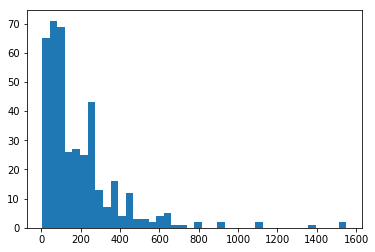

In [5]:
lengths = [(len(x),i) for i,x in enumerate(all_comments)]
lengths.sort()

_, refs = zip(*lengths[-55:-50])

sep = '-'*40 
some_txts = sep.join( all_comments[i] for i in refs )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

x,_ = zip(*lengths)
plt.hist(x, bins=40)

In [6]:
print(''.join([x for x in all_comments if len(x) <  250]  ) )


Can my ration book have a blue cover please Mrs May?

Here is the dictionary definition of "megalomania" - delusion about one's own power or importance (typically as a symptom of a manic or paranoid disorder).I rest my case!She thinks she's the effin Queen!

This week we have seen the very best of Fleabag and the very worst of Pleabag

Pity Marina didn’t find out what actually happened at the leaders meeting before repeating the claim that Corbyn walked out because Umunna was there...

Her statement got me almost as angry as Thatcher ever got me.


                            This comment was removed by a moderator because it didn't abide by our
                            community standards.
                            Replies may also be deleted. For more detail see our FAQs.

Don't worry, on April 1st it will all look like a harmless prank. April 2nd may not be so cheery but that is a long way off in UK politics!


                            This comment was removed by a moderato

In [90]:
lengths[-20:]

[(1866, 398),
 (1866, 1208),
 (1887, 548),
 (1917, 575),
 (1934, 812),
 (2012, 145),
 (2127, 174),
 (2150, 618),
 (2202, 1337),
 (2216, 248),
 (2331, 16),
 (2698, 274),
 (2700, 463),
 (2755, 342),
 (2918, 478),
 (4147, 36),
 (4183, 1199),
 (4955, 25),
 (4959, 21),
 (4960, 30)]

Calculate average length

In [93]:
x,y = zip(*lengths)
sum(x)/len(lengths)

388.78183069511357

(array([350., 363., 235., 156.,  97.,  73.,  47.,  39.,  19.,  19.,  15.,
          9.,   5.,   3.,   3.,   5.,   1.,   4.,   1.,   0.,   0.,   2.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([   5.   ,  128.875,  252.75 ,  376.625,  500.5  ,  624.375,
         748.25 ,  872.125,  996.   , 1119.875, 1243.75 , 1367.625,
        1491.5  , 1615.375, 1739.25 , 1863.125, 1987.   , 2110.875,
        2234.75 , 2358.625, 2482.5  , 2606.375, 2730.25 , 2854.125,
        2978.   , 3101.875, 3225.75 , 3349.625, 3473.5  , 3597.375,
        3721.25 , 3845.125, 3969.   , 4092.875, 4216.75 , 4340.625,
        4464.5  , 4588.375, 4712.25 , 4836.125, 4960.   ]),
 <a list of 40 Patch objects>)

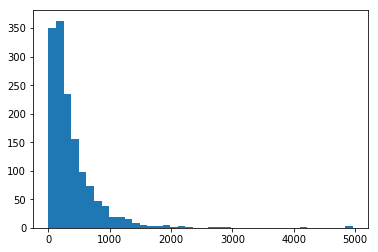

In [130]:
import textacy

In [134]:
doc = textacy.doc.Doc(some_txts)

In [135]:
stuff = list(textacy.extract.ngrams(doc, 
                            4, 
                            filter_stops=True, filter_punct=True, 
                            filter_nums=False))

In [136]:
def my_filter(x):
    pss = [token.pos_ for token in x]
    if u'\u2019s' in [token.orth_ for token in x]: return False
    if u'NOUN' in pss and not u'PROPN' in pss and u'PART' not in pss: return True
    return False
    
ngrams = [ x for x in stuff if my_filter(x)]
ngrams.sort( key=lambda x : x[0].lower_)     

In [142]:
[x for x in ngrams if 'math' in x.text.lower()]


[accepted that higher maths,
 actuality in maths education,
 Mathematics and logical thought,
 maths was without practical,
 maths in advanced physics,
 Maths should be elective,
 richer actuality in maths,
 world application of maths]

In [143]:
ngrams

['m a computer programmer,
 's no such thing,
 accepted that higher maths,
 actuality in maths education,
 advanced physics or writing,
 age is about giving,
 All these years later,
 ambushed by corporate capitalism,
 applicable to everyday life,
 applicable to the lives,
 average can I expect,
 beliefs you would find,
 block to a vast,
 calculus should be included,
 career they will want,
 children at year 7,
 children at that age,
 children have had good,
 choice when they're,
 come across the word,
 connected to practical life,
 country has a need,
 designers and creative thinkers,
 Do you expect children,
 educated widely knowledgeable public,
 education as an ideological,
 education at a young,
 enlightenment thinkers were far,
 fully understand the consequences,
 fully understanding the consequences,
 futility of the lottery,
 genealogy of this issue,
 geography on a daily,
 giving children the chance,
 great number of careers,
 guessing that the answer,
 head a different argumen